In [1]:
import torch
import pandas as pd
import numpy as np
# 新数据
# 读取所有数据
paths = [
    # '../data/processed_data_900_1.csv', '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
    # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
    '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
    # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
    # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
    # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
]

# 读取并拼接数据
# all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
# all_data = np.array(all_data)
# all_data.shape

In [2]:
all_data = []
for path in paths:
    data = pd.read_csv(path)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

In [4]:
all_data.shape

(1338, 1)

In [3]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
all_data

array([['(Mo3O9,91);(Mo3O9S2,13);(MoO2,5);(MoOS,11);(MoO2,13);(MoO,40);(MoOS2,3);(MoO,1);(MoOS2,14);(MoS,2);(MoOS2,1);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,4);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,12);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,15);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,6);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,13);(MoS,3);(MoO2S,1);(MoOS,76);(MoOS3,2);(MoOS,7);(MoOS3,7);(MoOS,49);(MoOS3,19);(MoS2,101);(Mo2S7,3);(MoS3,1);(Mo2S7,57);(Mo2S5,1);(Mo2S7,118);(MoO,25);(MoOS,16);(MoS,9);(MoS2,52);(MoO,6);(MoOS2,4);(MoS,1);(MoOS2,9);(MoS,156);(MoS3,9);(MoS,1);(MoS3,57);(MoS,1);(MoS3,68);(MoOS4,1);(MoS3,52);(MoS5,27);(MoS3,187);(MoOS4,1);(MoS3,84);(MoS5,269);(MoOS6,3);(MoS5,1);(MoOS6,4);(MoS3,1);(MoS5,1);(MoOS6,10);(MoS5,1);(MoOS6,1);(MoS5,1);(MoOS6,2);(MoS5,1);(MoOS6,3);(MoS5,158);(MoS6,4);(MoS4,1);(MoS6,759);(MoOS7,1);(MoS6,743);(MoS8,38);(MoS6,539);(MoOS7,1);(MoS6,2);(MoOS7,15);(MoS6,2);(MoOS7,6);(MoS6,1);(MoOS7,101);(MoS6,3);(MoOS7,123);(MoS6,321);(MoS8,208);(MoS10,1);(M

In [4]:
# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data)
processed = np.array(processed)
print(processed.shape)

(1338,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_45724\2383512409.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed = np.array(processed)


In [6]:
processed[1]

array([['Mo3O9', '91'],
       ['Mo3O9S2', '13'],
       ['Mo2O4', '5'],
       ...,
       ['MoS5', '1'],
       ['MoOS6', '32'],
       ['MoS5', '1']], dtype='<U11')

In [5]:
import numpy as np
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [6]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
# cy_data = [[incode(value[0]) for value in row] for row in cy_data]
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_45724\161354326.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(1338,)

In [8]:
cy_data[0]

[array([  3,   9,   0, 150]),
 array([3, 9, 2, 2]),
 array([3, 9, 0, 1]),
 array([ 3,  9,  2, 12]),
 array([ 1,  2,  0, 67]),
 array([1, 3, 0, 3]),
 array([ 1,  2,  0, 41]),
 array([1, 2, 2, 2]),
 array([1, 1, 1, 2]),
 array([ 1,  2,  0, 49]),
 array([1, 1, 0, 1]),
 array([1, 2, 0, 3]),
 array([1, 1, 0, 1]),
 array([1, 2, 0, 2]),
 array([1, 1, 0, 2]),
 array([1, 2, 0, 3]),
 array([1, 1, 0, 1]),
 array([1, 2, 0, 1]),
 array([1, 1, 0, 1]),
 array([1, 2, 0, 9]),
 array([1, 1, 0, 3]),
 array([ 1,  2,  0, 13]),
 array([1, 1, 0, 1]),
 array([1, 2, 0, 3]),
 array([  1,   1,   0, 128]),
 array([1, 1, 2, 1]),
 array([1, 1, 0, 1]),
 array([ 1,  1,  2, 20]),
 array([1, 0, 1, 2]),
 array([ 1,  1,  2, 18]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 2]),
 array([ 1,  1,  2, 11]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 6]),
 array([1, 0, 1, 1]),
 array([ 1,  1,  2, 15]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 3]),
 array([1, 1, 4, 6]),
 a

In [7]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (1338,)
X.shape (1338,)
y.shape (1338,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_45724\1166615506.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_45724\1166615506.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_45724\1166615506.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

In [8]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (802,)
X_test.shape (536,)
y_train.shape (802,)
y_test.shape (536,)


In [86]:
X_train.shape

(394618, 10, 3)

In [9]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (394618, 10, 4)
X_test.shape (264803, 10, 4)
y_train.shape (394618, 4)
y_test.shape (264803, 4)


In [14]:
y_train = y_train[:, 3]
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train.shape, y_test.shape

((394618, 1), (264803, 1))

In [12]:
# 假设 X_train, X_test, y_train, y_test 的形状分别是 (394618, 10, 4), (264803, 10, 4), (394618, 4), (264803, 4)
# 扩展 y_train 和 y_test 的维度，将其从 (n, 4) 扩展到 (n, 10, 4)
y_train_expanded = np.expand_dims(y_train, axis=1)  # 将 y_train 从 (n, 4) 转换为 (n, 1, 4)
y_train_expanded = np.tile(y_train_expanded, (1, 10, 1))  # 将其复制 10 次，形状变为 (n, 10, 4)

y_test_expanded = np.expand_dims(y_test, axis=1)  # 将 y_test 从 (n, 4) 转换为 (n, 1, 4)
y_test_expanded = np.tile(y_test_expanded, (1, 10, 1))  # 将其复制 10 次，形状变为 (n, 10, 4)

y_train_expanded = y_train_expanded[:, :, :-1]
y_test_expanded = y_test_expanded[:, :, :-1]

# 检查扩展后的 y_train 和 y_test 的形状
print('y_train_expanded.shape', y_train_expanded.shape)
print('y_test_expanded.shape', y_test_expanded.shape)

# 将 y_train_expanded 和 X_train 沿特征维度拼接，形成新的 X_train
X_train_new = np.concatenate([X_train, y_train_expanded], axis=-1)  # 结果形状为 (n, 10, 8)
X_test_new = np.concatenate([X_test, y_test_expanded], axis=-1)  # 结果形状为 (n, 10, 8)

# 检查新的 X_train 和 X_test 的形状
print('X_train_new.shape', X_train_new.shape)
print('X_test_new.shape', X_test_new.shape)


y_train_expanded.shape (394618, 10, 3)
y_test_expanded.shape (264803, 10, 3)
X_train_new.shape (394618, 10, 7)
X_test_new.shape (264803, 10, 7)


In [19]:
X_train = X_train_new
X_test = X_test_new

In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化scaler
scaler = MinMaxScaler()

# Reshape the data to 2D for fitting the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (130657*10, 4)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_scaled.reshape(X_train.shape)  # (130657, 10, 4)
X_test_normalized = X_test_scaled.reshape(X_test.shape)    # (102104, 10, 4)

# y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (130657*10, 4)
# y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])    # (102104*10, 4)

# # y_train_reshaped = y_train.reshape(-1, 1)  # (130657*10, 4)
# # y_test_reshaped = y_test.reshape(-1, 1)    # (102104*10, 4)

# # Fit the scaler on training data and transform both train and test sets
# y_train_scaled = scaler.fit_transform(y_train_reshaped)
# y_test_scaled = scaler.transform(y_test_reshaped)

# # Reshape back to original dimensions
# y_train_normalized = y_train_scaled.reshape(y_train.shape)  # (130657, 10, 4)
# y_test_normalized = y_test_scaled.reshape(y_test.shape)    # (102104, 10, 4)

# X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

In [15]:
# 对时间特征进行对数变换
y_train_normalized = np.log(y_train + 1)  # 加1避免对数零值
y_test_normalized = np.log(y_test + 1)

In [21]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train))
train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))

# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test))

X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

((394618, 10, 7), (394618, 1), (264803, 10, 7), (264803, 1))

In [ ]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 128
num_layers = 2
batch_size = 256
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
 
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
    
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)  # Use softmax for multi-class classification

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Initialize cell state
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         # Apply softmax to the output layer
#         out = self.softmax(out)
#         return out
    
# LSTM_SelfAttention model
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1)
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1)
        # output的形状是(batch_size, hidden_size)
        return output
    
# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 7
num_classes= 1
# model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5, num_heads=8)
# print('num_classes:', num_classes)
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.4, patience=3, min_lr=1e-6, verbose=True)

# 训练模型
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 50
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if val_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

# 保存最好的模型
torch.save(best_model, '../model/mul_T900_sttgs.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
train epoch 0: 100%|██████████| 1542/1542 [00:06<00:00, 244.36batch/s]


Epoch 1/300, Train Loss: 2.1630796751855415, Validation Loss: 1.9198910960828623 Current learning rate: 0.0001


train epoch 1: 100%|██████████| 1542/1542 [00:10<00:00, 154.08batch/s]


Epoch 2/300, Train Loss: 1.8503323385996886, Validation Loss: 1.7158257192171713 Current learning rate: 0.0001


train epoch 2: 100%|██████████| 1542/1542 [00:05<00:00, 262.72batch/s]


Epoch 3/300, Train Loss: 1.7559874805726894, Validation Loss: 1.6767103944423694 Current learning rate: 0.0001


train epoch 3: 100%|██████████| 1542/1542 [00:05<00:00, 262.47batch/s]


Epoch 4/300, Train Loss: 1.6932974714694011, Validation Loss: 1.6103979652054643 Current learning rate: 0.0001


train epoch 4: 100%|██████████| 1542/1542 [00:05<00:00, 261.19batch/s]


Epoch 5/300, Train Loss: 1.6253646563656445, Validation Loss: 1.5897493257614725 Current learning rate: 0.0001


train epoch 5: 100%|██████████| 1542/1542 [00:05<00:00, 262.24batch/s]


Epoch 6/300, Train Loss: 1.5958120293731666, Validation Loss: 1.6345842646227942 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 50


train epoch 6: 100%|██████████| 1542/1542 [00:05<00:00, 269.54batch/s]


Epoch 7/300, Train Loss: 1.5762090834314257, Validation Loss: 1.6538386574401949 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 50


train epoch 7: 100%|██████████| 1542/1542 [00:05<00:00, 264.05batch/s]


Epoch 8/300, Train Loss: 1.5579228509222331, Validation Loss: 1.6660517292322168 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 50


train epoch 8: 100%|██████████| 1542/1542 [00:05<00:00, 268.78batch/s]


Epoch 9/300, Train Loss: 1.5446797019467435, Validation Loss: 1.6344148996947467 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 50


train epoch 9: 100%|██████████| 1542/1542 [00:05<00:00, 260.79batch/s]


Epoch 10/300, Train Loss: 1.5321691561533783, Validation Loss: 1.586795815753476 Current learning rate: 0.0001


train epoch 10: 100%|██████████| 1542/1542 [00:06<00:00, 247.08batch/s]


Epoch 11/300, Train Loss: 1.51960074696714, Validation Loss: 1.547859983916444 Current learning rate: 0.0001


train epoch 11: 100%|██████████| 1542/1542 [00:06<00:00, 244.97batch/s]


Epoch 12/300, Train Loss: 1.5084588940118846, Validation Loss: 1.5239902570339792 Current learning rate: 0.0001


train epoch 12: 100%|██████████| 1542/1542 [00:06<00:00, 243.25batch/s]


Epoch 13/300, Train Loss: 1.500297922085386, Validation Loss: 1.506469335561789 Current learning rate: 0.0001


train epoch 13: 100%|██████████| 1542/1542 [00:05<00:00, 260.12batch/s]


Epoch 14/300, Train Loss: 1.4908176060046048, Validation Loss: 1.5021014635977539 Current learning rate: 0.0001


train epoch 14: 100%|██████████| 1542/1542 [00:05<00:00, 263.31batch/s]


Epoch 15/300, Train Loss: 1.4840565424910162, Validation Loss: 1.487781060317864 Current learning rate: 0.0001


train epoch 15: 100%|██████████| 1542/1542 [00:05<00:00, 264.18batch/s]


Epoch 16/300, Train Loss: 1.4780995501386516, Validation Loss: 1.4757235700093605 Current learning rate: 0.0001


train epoch 16: 100%|██████████| 1542/1542 [00:05<00:00, 264.67batch/s]


Epoch 17/300, Train Loss: 1.468555358326698, Validation Loss: 1.4734453103392597 Current learning rate: 0.0001


train epoch 17: 100%|██████████| 1542/1542 [00:05<00:00, 263.55batch/s]


Epoch 18/300, Train Loss: 1.463814286860588, Validation Loss: 1.4688977248282824 Current learning rate: 0.0001


train epoch 18: 100%|██████████| 1542/1542 [00:05<00:00, 261.15batch/s]


Epoch 19/300, Train Loss: 1.4551989970929273, Validation Loss: 1.460556271009975 Current learning rate: 0.0001


train epoch 19: 100%|██████████| 1542/1542 [00:05<00:00, 263.28batch/s]


Epoch 20/300, Train Loss: 1.4497393227041, Validation Loss: 1.4548835060590708 Current learning rate: 0.0001


train epoch 20: 100%|██████████| 1542/1542 [00:05<00:00, 259.53batch/s]


Epoch 21/300, Train Loss: 1.44413333841335, Validation Loss: 1.4504657092589688 Current learning rate: 0.0001


train epoch 21: 100%|██████████| 1542/1542 [00:05<00:00, 271.16batch/s]


Epoch 22/300, Train Loss: 1.438195163773037, Validation Loss: 1.4479493232740872 Current learning rate: 0.0001


train epoch 22: 100%|██████████| 1542/1542 [00:05<00:00, 269.21batch/s]


Epoch 23/300, Train Loss: 1.431841763569919, Validation Loss: 1.4436837276110903 Current learning rate: 0.0001


train epoch 23: 100%|██████████| 1542/1542 [00:05<00:00, 269.97batch/s]


Epoch 24/300, Train Loss: 1.4260010516751755, Validation Loss: 1.436225428155079 Current learning rate: 0.0001


train epoch 24: 100%|██████████| 1542/1542 [00:06<00:00, 255.37batch/s]


Epoch 25/300, Train Loss: 1.4191423013284512, Validation Loss: 1.4236055575419164 Current learning rate: 0.0001


train epoch 25: 100%|██████████| 1542/1542 [00:06<00:00, 243.25batch/s]


Epoch 26/300, Train Loss: 1.412471400527948, Validation Loss: 1.4206386767291792 Current learning rate: 0.0001


train epoch 26: 100%|██████████| 1542/1542 [00:06<00:00, 242.03batch/s]


Epoch 27/300, Train Loss: 1.4075668004719508, Validation Loss: 1.416707655168386 Current learning rate: 0.0001


train epoch 27: 100%|██████████| 1542/1542 [00:06<00:00, 246.41batch/s]


Epoch 28/300, Train Loss: 1.402407821398301, Validation Loss: 1.4092978291465463 Current learning rate: 0.0001


train epoch 28: 100%|██████████| 1542/1542 [00:05<00:00, 263.43batch/s]


Epoch 29/300, Train Loss: 1.3981737057870465, Validation Loss: 1.4068506709619422 Current learning rate: 0.0001


train epoch 29: 100%|██████████| 1542/1542 [00:10<00:00, 153.36batch/s]


Epoch 30/300, Train Loss: 1.392259160184752, Validation Loss: 1.4082659669544386 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 50


train epoch 30: 100%|██████████| 1542/1542 [00:05<00:00, 261.26batch/s]


Epoch 31/300, Train Loss: 1.3885139241602016, Validation Loss: 1.3984314178786992 Current learning rate: 0.0001


train epoch 31: 100%|██████████| 1542/1542 [00:05<00:00, 262.47batch/s]


Epoch 32/300, Train Loss: 1.3846382403072217, Validation Loss: 1.3996681069982224 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 50


train epoch 32: 100%|██████████| 1542/1542 [00:05<00:00, 260.83batch/s]


Epoch 33/300, Train Loss: 1.3812667972054309, Validation Loss: 1.4023423084602264 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 50


train epoch 33: 100%|██████████| 1542/1542 [00:05<00:00, 261.95batch/s]


Epoch 34/300, Train Loss: 1.3760730637534584, Validation Loss: 1.4008090384052572 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 50


train epoch 34: 100%|██████████| 1542/1542 [00:05<00:00, 260.47batch/s]


Epoch 35/300, Train Loss: 1.373728669870611, Validation Loss: 1.4117939112267057 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 50


train epoch 35: 100%|██████████| 1542/1542 [00:05<00:00, 268.38batch/s]


Epoch 36/300, Train Loss: 1.36949655746053, Validation Loss: 1.4002065301229412 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 50


train epoch 36: 100%|██████████| 1542/1542 [00:05<00:00, 267.65batch/s]


Epoch 37/300, Train Loss: 1.3652862184397132, Validation Loss: 1.406095790632681 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 50


train epoch 37: 100%|██████████| 1542/1542 [00:05<00:00, 265.51batch/s]


Epoch 38/300, Train Loss: 1.3631250080489463, Validation Loss: 1.4009001983968532 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 50


train epoch 38: 100%|██████████| 1542/1542 [00:05<00:00, 258.38batch/s]


Epoch 39/300, Train Loss: 1.3585387642088258, Validation Loss: 1.4071868172302338 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 50


train epoch 39: 100%|██████████| 1542/1542 [00:06<00:00, 237.56batch/s]


Epoch 40/300, Train Loss: 1.3543420411385452, Validation Loss: 1.3979171390118805 Current learning rate: 0.0001


train epoch 40: 100%|██████████| 1542/1542 [00:06<00:00, 239.46batch/s]


Epoch 41/300, Train Loss: 1.3535414764466762, Validation Loss: 1.39038620169324 Current learning rate: 0.0001


train epoch 41: 100%|██████████| 1542/1542 [00:06<00:00, 246.73batch/s]


Epoch 42/300, Train Loss: 1.3503243215527052, Validation Loss: 1.3790765156204574 Current learning rate: 0.0001


train epoch 42: 100%|██████████| 1542/1542 [00:06<00:00, 254.02batch/s]


Epoch 43/300, Train Loss: 1.344989705777663, Validation Loss: 1.3777886973343034 Current learning rate: 0.0001


train epoch 43: 100%|██████████| 1542/1542 [00:05<00:00, 258.44batch/s]


Epoch 44/300, Train Loss: 1.3421141625745596, Validation Loss: 1.36854345422724 Current learning rate: 0.0001


train epoch 44: 100%|██████████| 1542/1542 [00:05<00:00, 260.62batch/s]


Epoch 45/300, Train Loss: 1.340185155635446, Validation Loss: 1.3665486605127077 Current learning rate: 0.0001


train epoch 45: 100%|██████████| 1542/1542 [00:05<00:00, 260.06batch/s]


Epoch 46/300, Train Loss: 1.339276465363849, Validation Loss: 1.3564706866435958 Current learning rate: 0.0001


train epoch 46: 100%|██████████| 1542/1542 [00:06<00:00, 255.81batch/s]


Epoch 47/300, Train Loss: 1.336327189292116, Validation Loss: 1.3522213940027255 Current learning rate: 0.0001


train epoch 47: 100%|██████████| 1542/1542 [00:05<00:00, 260.79batch/s]


Epoch 48/300, Train Loss: 1.332551306681333, Validation Loss: 1.3527418984739101 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 50


train epoch 48: 100%|██████████| 1542/1542 [00:05<00:00, 258.61batch/s]


Epoch 49/300, Train Loss: 1.330693083930031, Validation Loss: 1.3443426091025994 Current learning rate: 0.0001


train epoch 49: 100%|██████████| 1542/1542 [00:05<00:00, 266.50batch/s]


Epoch 50/300, Train Loss: 1.3314866016579046, Validation Loss: 1.3381557826978574 Current learning rate: 0.0001


train epoch 50: 100%|██████████| 1542/1542 [00:05<00:00, 264.80batch/s]


Epoch 51/300, Train Loss: 1.3307747904853908, Validation Loss: 1.3447430179314912 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 50


train epoch 51: 100%|██████████| 1542/1542 [00:05<00:00, 263.56batch/s]


Epoch 52/300, Train Loss: 1.3245889725774798, Validation Loss: 1.3303075939416886 Current learning rate: 0.0001


train epoch 52: 100%|██████████| 1542/1542 [00:05<00:00, 266.68batch/s]


Epoch 53/300, Train Loss: 1.3229865653853472, Validation Loss: 1.337014774395072 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 50


train epoch 53: 100%|██████████| 1542/1542 [00:06<00:00, 247.49batch/s]


Epoch 54/300, Train Loss: 1.320806542220592, Validation Loss: 1.3417612868662618 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 50


train epoch 54: 100%|██████████| 1542/1542 [00:06<00:00, 250.36batch/s]


Epoch 55/300, Train Loss: 1.319386097466049, Validation Loss: 1.3428221538159006 Current learning rate: 0.0001
EarlyStopping counter: 18 out of 50


train epoch 55:  11%|█▏        | 177/1542 [00:00<00:05, 247.99batch/s]

In [127]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

In [55]:
# 数据转回原始尺度
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)

ValueError: non-broadcastable output operand with shape (264803,1) doesn't match the broadcast shape (264803,4)

In [25]:
# 数据转回非log
predictions = np.exp(predictions) - 1
targets = np.exp(targets) - 1

In [92]:
predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [57]:
predictions_s = predictions
targets_s = targets
predictions = predictions[:, :-1]
targets = targets[:, :-1]

predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 322.61374
Mean Squared Error (MSE): 104079.62
Mean Absolute Error (MAE): 50.55449
R^2 Score: 0.036889806408571646


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

In [94]:
#保存预测结果
np.savez('../results/mul_T900_ss.npz', arr1=targets, arr2=predictions)

In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

In [32]:
y_test.shape, predictions.shape

((264803, 1), (264803, 1))

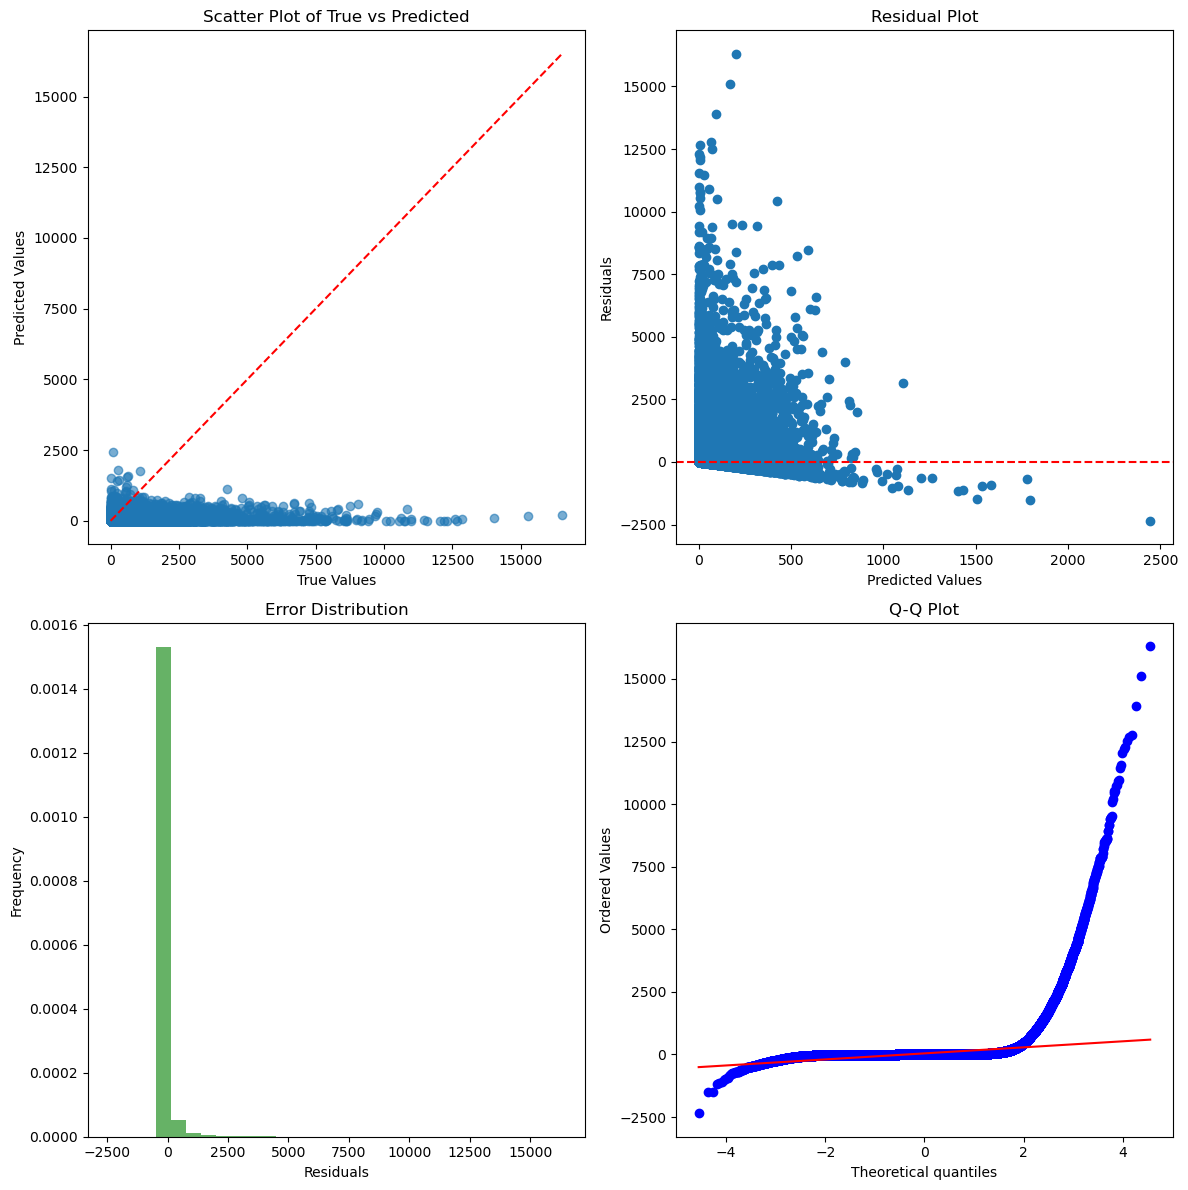

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 假设 y_test 是真实值，predictions 是预测值
residuals = y_test - predictions
residuals = residuals.flatten()  # 将 residuals 转换为一维数组

# 创建 2x2 的子图（一个 2 行 2 列的布局）
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 绘制散点图
axes[0, 0].scatter(y_test, predictions, alpha=0.6)
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Scatter Plot of True vs Predicted')

# 绘制残差图
axes[0, 1].scatter(predictions, residuals)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 绘制误差分布图
axes[1, 0].hist(residuals, bins=30, density=True, alpha=0.6, color='g')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution')

# 绘制 Q-Q 图
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

# 调整布局
plt.tight_layout()
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

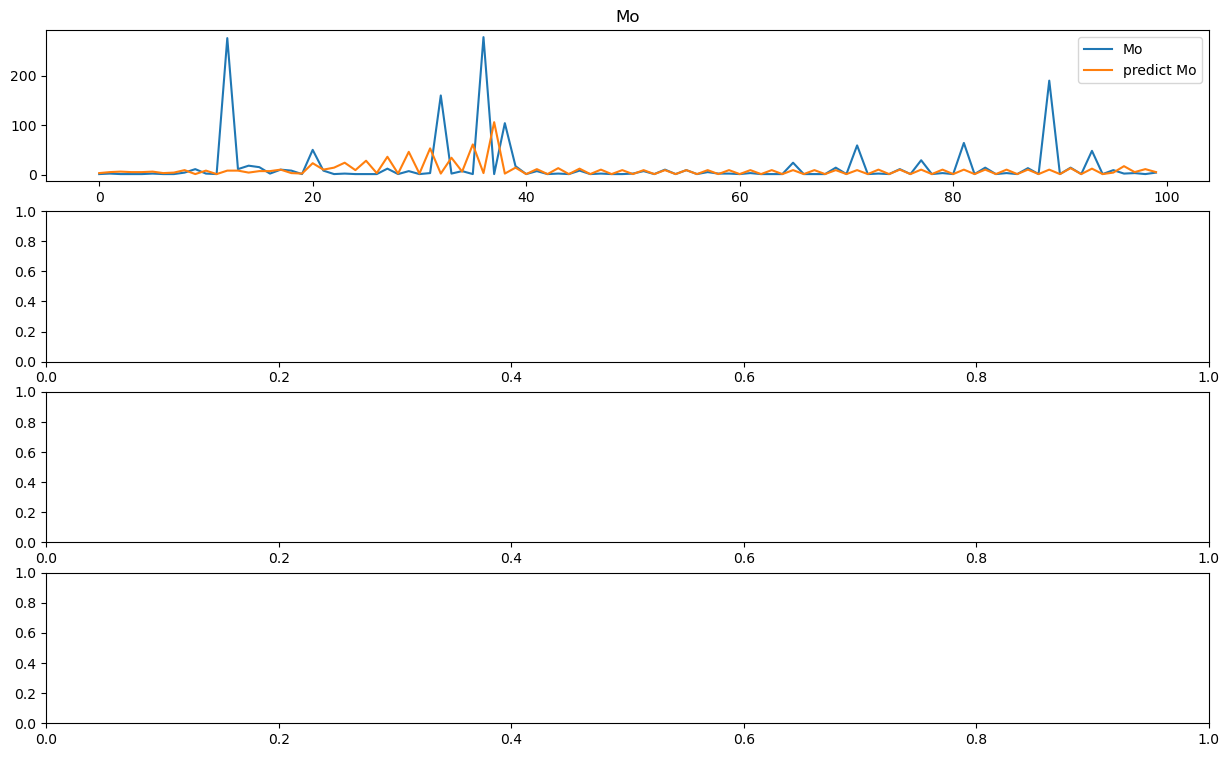

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end]
t1 = t_round[start:end]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:], label='Mo')
axs[0].plot(p1[:], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

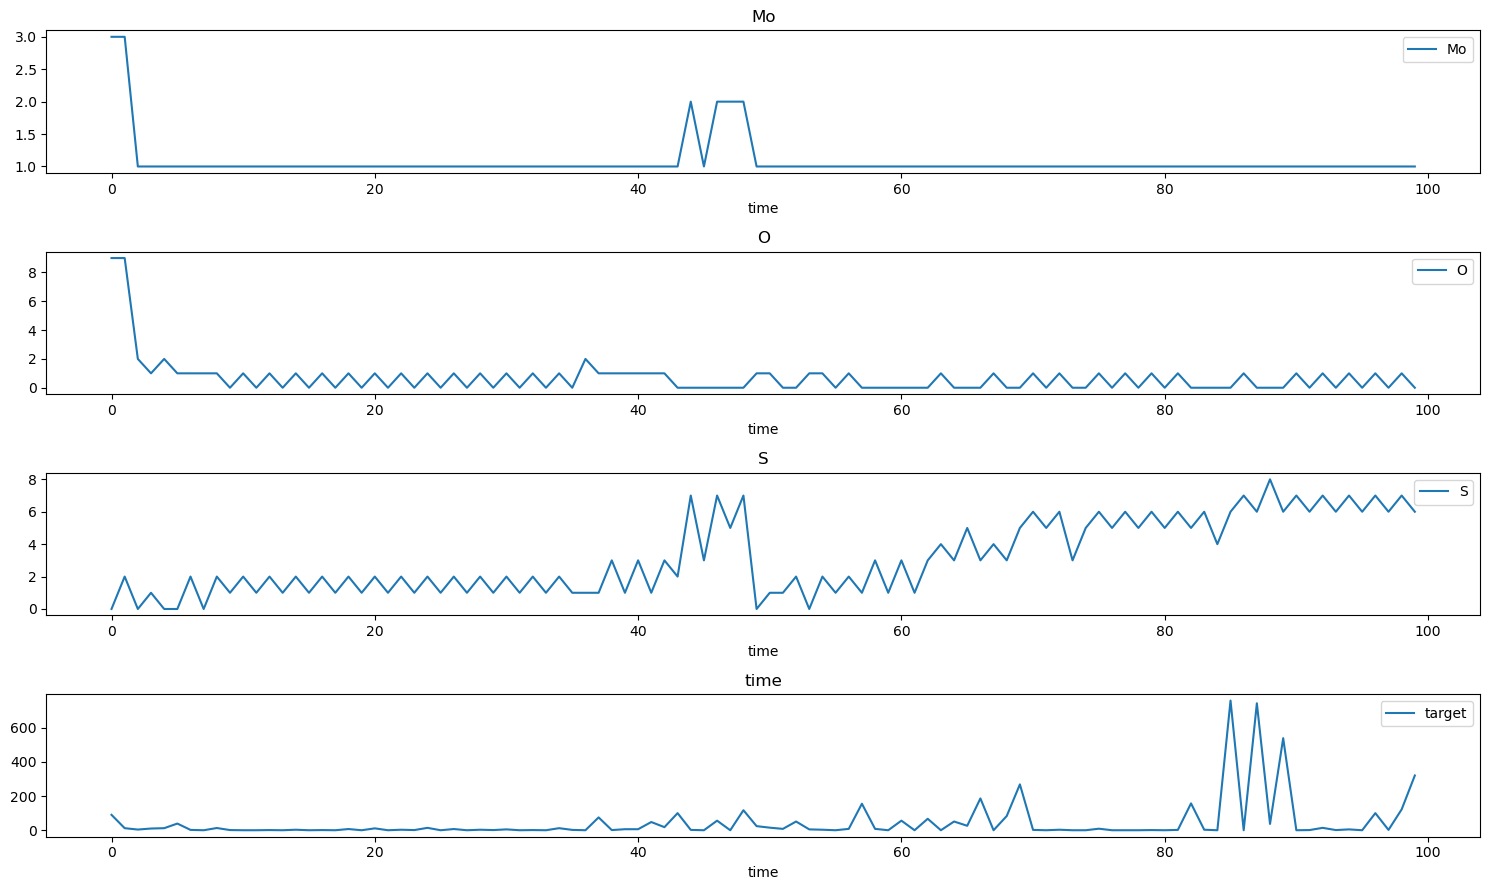

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [1]:
import numpy as np
ss = np.load('../results/mul_T900_ss.npz')
ss_targets = ss['arr1']
ss_predictions = ss['arr2']

sts = np.load('../results/mul_T900_sts.npz')
sts_targets = sts['arr1']
sts_predictions = sts['arr2']

stst = np.load('../results/mul_T900_stst.npz')
stst_targets = stst['arr1']
stst_predictions = stst['arr2']

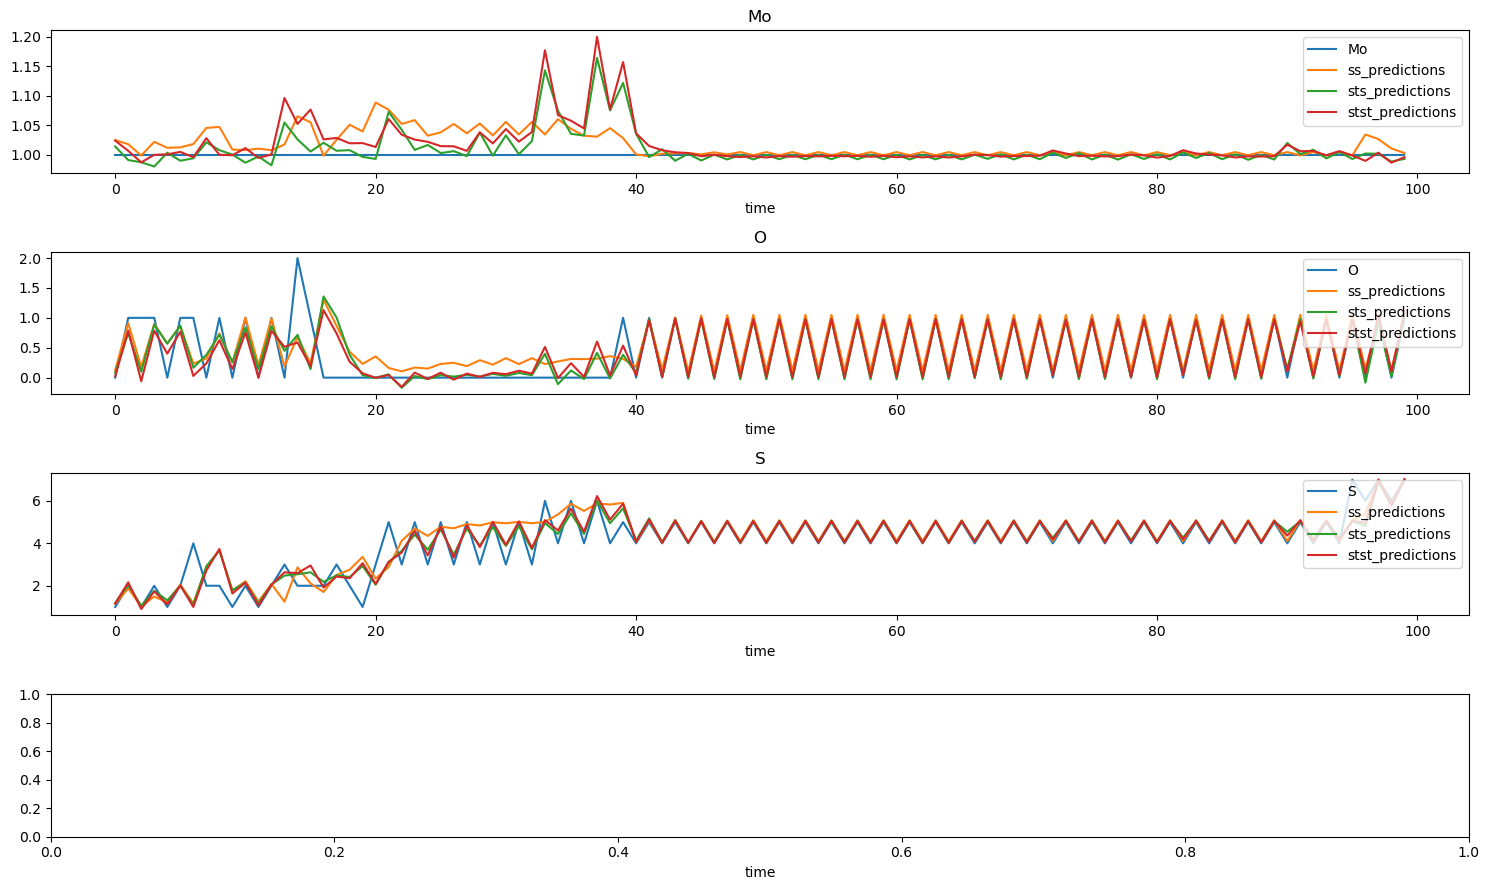

In [3]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = stst_targets #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(ss_predictions[start:end, 0], label='ss_predictions')
axs[0].plot(sts_predictions[start:end, 0], label='sts_predictions')
axs[0].plot(stst_predictions[start:end, 0], label='stst_predictions')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(ss_predictions[start:end, 1], label='ss_predictions')
axs[1].plot(sts_predictions[start:end, 1], label='sts_predictions')
axs[1].plot(stst_predictions[start:end, 1], label='stst_predictions')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(ss_predictions[start:end, 2], label='ss_predictions')
axs[2].plot(sts_predictions[start:end, 2], label='sts_predictions')
axs[2].plot(stst_predictions[start:end, 2], label='stst_predictions')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# # axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')